# PaaS Thesis Evaluation - Experimental Results Analysis

This notebook analyzes the experimental results from the Protocol-Aware Agentic Swarm (PaaS) resilience evaluation.

## Experimental Setup

- **900 total experiments** (300 per condition)
- **3 conditions**: Baseline, Reconstruction, Full System
- **4 scenarios**: Vendor Onboarding, Product Launch, Customer Feedback, Inventory Crisis
- **Key metrics**: MTTR-A, Task Success Rate, Recovery Success Rate


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from pathlib import Path
import os

# Set style for thesis-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12

# Color palette for all conditions (including comparison baselines and Phase B/C)
COLORS = {
    'baseline': '#e74c3c',        # Red
    'simple_retry': '#f39c12',    # Orange
    'checkpoint_only': '#9b59b6', # Purple
    'llm_only': '#1abc9c',        # Teal
    'automata_only': '#e67e22',   # Dark Orange
    'reconstruction': '#3498db',  # Blue
    'full_system': '#2ecc71',     # Green
    'real_api': '#16a085',        # Dark Teal
    'exponential_backoff': '#d35400',  # Dark Orange
    'circuit_breaker': '#8e44ad',      # Dark Purple
    'semantic_only': '#27ae60',        # Dark Green
    'full_no_semantic': '#f1c40f',     # Yellow
}

CONDITION_LABELS = {
    'baseline': 'Baseline\n(No Resilience)',
    'simple_retry': 'Simple Retry\n(3 attempts)',
    'checkpoint_only': 'Checkpoint\nOnly',
    'llm_only': 'LLM Only\n(No Peer)',
    'automata_only': 'Automata\nOnly',
    'reconstruction': 'LLM + Peer\nContext',
    'full_system': 'Full PaaS\n(Hybrid)',
    'real_api': 'Real API\n(Shopify)',
    'exponential_backoff': 'Exponential\nBackoff',
    'circuit_breaker': 'Circuit\nBreaker',
    'semantic_only': 'Semantic\nOnly',
    'full_no_semantic': 'Full - Semantic\n(Ablation)',
}

# All conditions in order of expected performance
ALL_CONDITIONS = ['baseline', 'simple_retry', 'checkpoint_only', 'llm_only', 'automata_only', 'reconstruction', 'full_system']

# Original 3 conditions
ORIGINAL_CONDITIONS = ['baseline', 'reconstruction', 'full_system']


## 1. Load Experimental Data


In [2]:
# Load raw data for each condition
data_dir = Path('../data/experiments/raw')

dfs = {}
for condition in ['baseline', 'reconstruction', 'full_system']:
    df = pd.read_csv(data_dir / f'{condition}_runs.csv')
    df['condition'] = condition
    dfs[condition] = df

# Combine all data
df_all = pd.concat(dfs.values(), ignore_index=True)

print(f"Total experiments: {len(df_all)}")
print(f"\nExperiments per condition:")
print(df_all['condition'].value_counts())


Total experiments: 900

Experiments per condition:
condition
baseline          300
reconstruction    300
full_system       300
Name: count, dtype: int64


In [3]:
# Load summary metrics
with open('../data/experiments/summary/metrics_summary.json', 'r') as f:
    summary = json.load(f)

print("=== SUMMARY STATISTICS ===")
print(f"Total runs: {summary['total_runs']}")
print(f"Overall success rate: {summary['success_rate']:.1%}")
print(f"Recovery success rate: {summary['recovery_success_rate']:.1%}")
print(f"Mean MTTR: {summary['mttr_mean']:.3f}s" if summary['mttr_mean'] else "Mean MTTR: N/A")


=== SUMMARY STATISTICS ===
Total runs: 900
Overall success rate: 71.3%
Recovery success rate: 83.1%
Mean MTTR: 0.122s


## 2. Summary Statistics Table


In [4]:
# Create summary table for thesis
summary_data = []
for condition, metrics in summary['metrics_by_condition'].items():
    summary_data.append({
        'Condition': CONDITION_LABELS[condition].replace('\n', ' '),
        'Total Runs': metrics['total_runs'],
        'Success Rate': f"{metrics['success_rate']:.1%}",
        'Recovery Rate': f"{metrics['recovery_rate']:.1%}" if metrics['recovery_rate'] > 0 else 'N/A',
        'MTTR Mean (s)': f"{metrics['mttr_mean']:.3f}" if metrics['mttr_mean'] else 'N/A',
        'MTTR P50 (s)': f"{metrics['mttr_p50']:.3f}" if metrics['mttr_p50'] else 'N/A',
    })

summary_table = pd.DataFrame(summary_data)
print("\n=== TABLE 1: Experimental Results by Condition ===")
display(summary_table)



=== TABLE 1: Experimental Results by Condition ===


,Condition,Total Runs,Success Rate,Recovery Rate,MTTR Mean (s),MTTR P50 (s)
0,Baseline (No Resilience),300,35.7%,N/A,N/A,N/A
1,LLM + Peer Context,300,83.7%,74.7%,0.101,0.105
2,Full PaaS (Hybrid),300,94.7%,91.6%,0.139,0.135


## 3. Success Rate Comparison (Bar Chart)


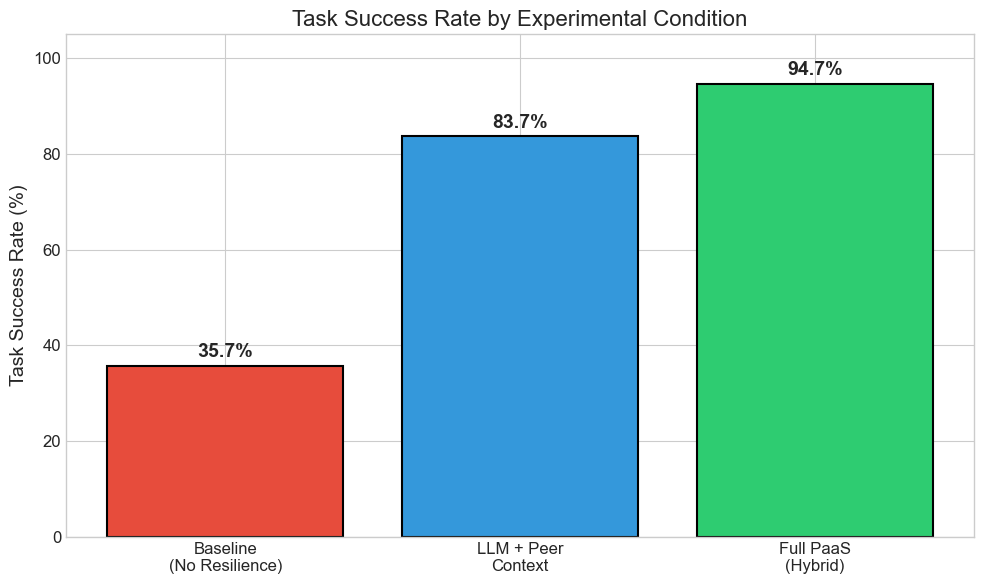

Saved: success_rate_comparison.png


In [5]:
# Create plots directory
plots_dir = Path('../data/experiments/plots')
plots_dir.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 6))

conditions = ['baseline', 'reconstruction', 'full_system']
success_rates = [summary['metrics_by_condition'][c]['success_rate'] * 100 for c in conditions]
colors = [COLORS[c] for c in conditions]

bars = ax.bar(range(len(conditions)), success_rates, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, rate in zip(bars, success_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_xticks(range(len(conditions)))
ax.set_xticklabels([CONDITION_LABELS[c] for c in conditions])
ax.set_ylabel('Task Success Rate (%)')
ax.set_title('Task Success Rate by Experimental Condition')
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig(plots_dir / 'success_rate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: success_rate_comparison.png")


## 4. Recovery Rate Comparison


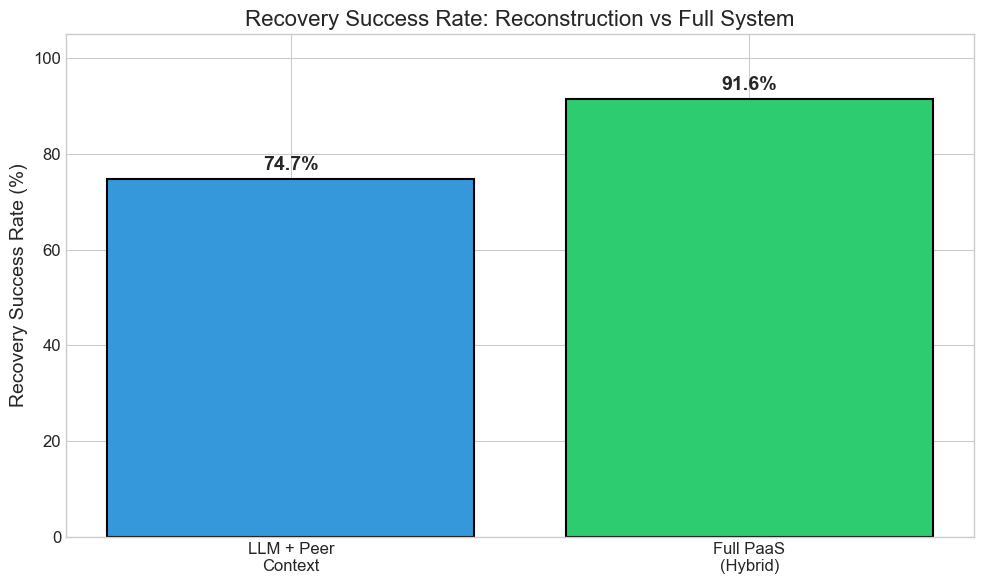

Saved: recovery_rate_comparison.png


In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

# Only show conditions with recovery
recovery_conditions = ['reconstruction', 'full_system']
recovery_rates = [summary['metrics_by_condition'][c]['recovery_rate'] * 100 for c in recovery_conditions]
colors = [COLORS[c] for c in recovery_conditions]

bars = ax.bar(range(len(recovery_conditions)), recovery_rates, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, rate in zip(bars, recovery_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_xticks(range(len(recovery_conditions)))
ax.set_xticklabels([CONDITION_LABELS[c] for c in recovery_conditions])
ax.set_ylabel('Recovery Success Rate (%)')
ax.set_title('Recovery Success Rate: Reconstruction vs Full System')
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig(plots_dir / 'recovery_rate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: recovery_rate_comparison.png")


## 5. MTTR Distribution (Histogram)


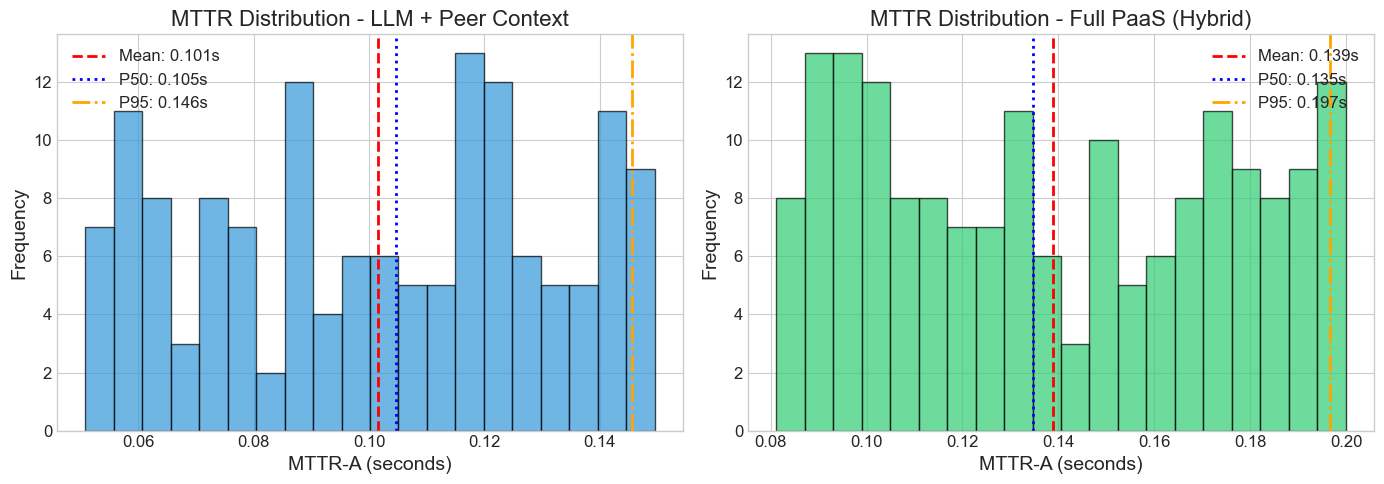

Saved: mttr_distribution.png


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter for successful recoveries with MTTR data
for ax, condition in zip(axes, ['reconstruction', 'full_system']):
    mttr_data = df_all[(df_all['condition'] == condition) & 
                       (df_all['recovery_success'] == True) &
                       (df_all['mttr_seconds'].notna())]['mttr_seconds']
    
    if len(mttr_data) > 0:
        ax.hist(mttr_data, bins=20, color=COLORS[condition], edgecolor='black', alpha=0.7)
        
        # Add statistics
        mean_mttr = mttr_data.mean()
        p50_mttr = mttr_data.median()
        p95_mttr = mttr_data.quantile(0.95)
        
        ax.axvline(mean_mttr, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_mttr:.3f}s')
        ax.axvline(p50_mttr, color='blue', linestyle=':', linewidth=2, label=f'P50: {p50_mttr:.3f}s')
        ax.axvline(p95_mttr, color='orange', linestyle='-.', linewidth=2, label=f'P95: {p95_mttr:.3f}s')
        
        ax.set_xlabel('MTTR-A (seconds)')
        ax.set_ylabel('Frequency')
        ax.set_title(f'MTTR Distribution - {CONDITION_LABELS[condition].replace(chr(10), " ")}')
        ax.legend()

plt.tight_layout()
plt.savefig(plots_dir / 'mttr_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: mttr_distribution.png")


## 6. Statistical Significance Tests


In [8]:
print("=== STATISTICAL SIGNIFICANCE TESTS ===")
print("\n--- Success Rate Comparisons (Chi-squared test) ---")

# Compare success rates using chi-squared test
conditions = ['baseline', 'reconstruction', 'full_system']
comparisons = [
    ('baseline', 'reconstruction'),
    ('baseline', 'full_system'),
    ('reconstruction', 'full_system')
]

test_results = []
for c1, c2 in comparisons:
    # Get success counts
    s1 = df_all[df_all['condition'] == c1]['success'].sum()
    n1 = len(df_all[df_all['condition'] == c1])
    s2 = df_all[df_all['condition'] == c2]['success'].sum()
    n2 = len(df_all[df_all['condition'] == c2])
    
    # Create contingency table
    contingency = [[s1, n1-s1], [s2, n2-s2]]
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    print(f"\n{c1.upper()} vs {c2.upper()}:")
    print(f"  Chi² = {chi2:.2f}, p = {p_value:.4e} {significance}")
    print(f"  Success rates: {s1/n1:.1%} vs {s2/n2:.1%}")
    
    test_results.append({
        'Comparison': f'{c1} vs {c2}',
        'Chi-squared': f'{chi2:.2f}',
        'p-value': f'{p_value:.4e}',
        'Significant': significance
    })


=== STATISTICAL SIGNIFICANCE TESTS ===

--- Success Rate Comparisons (Chi-squared test) ---

BASELINE vs RECONSTRUCTION:
  Chi² = 141.62, p = 1.1775e-32 ***
  Success rates: 35.7% vs 83.7%

BASELINE vs FULL_SYSTEM:
  Chi² = 227.43, p = 2.1636e-51 ***
  Success rates: 35.7% vs 94.7%

RECONSTRUCTION vs FULL_SYSTEM:
  Chi² = 17.67, p = 2.6303e-05 ***
  Success rates: 83.7% vs 94.7%


In [9]:
print("\n--- MTTR Comparison (t-test) ---")

# Get MTTR values for reconstruction and full_system
mttr_recon = df_all[(df_all['condition'] == 'reconstruction') & 
                    (df_all['recovery_success'] == True)]['mttr_seconds'].dropna()
mttr_full = df_all[(df_all['condition'] == 'full_system') & 
                   (df_all['recovery_success'] == True)]['mttr_seconds'].dropna()

if len(mttr_recon) > 0 and len(mttr_full) > 0:
    t_stat, p_value = stats.ttest_ind(mttr_recon, mttr_full)
    
    print(f"\nReconstruction vs Full System MTTR:")
    print(f"  Reconstruction: mean={mttr_recon.mean():.3f}s, std={mttr_recon.std():.3f}s (n={len(mttr_recon)})")
    print(f"  Full System:    mean={mttr_full.mean():.3f}s, std={mttr_full.std():.3f}s (n={len(mttr_full)})")
    print(f"  t-statistic = {t_stat:.3f}")
    print(f"  p-value = {p_value:.4e}")
    print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")



--- MTTR Comparison (t-test) ---

Reconstruction vs Full System MTTR:
  Reconstruction: mean=0.101s, std=0.030s (n=145)
  Full System:    mean=0.139s, std=0.037s (n=174)
  t-statistic = -9.845
  p-value = 3.9506e-20
  Significant at α=0.05: Yes


## 7. Confidence Intervals


In [10]:
print("=== 95% CONFIDENCE INTERVALS ===")

def wilson_ci(successes, trials, confidence=0.95):
    """Calculate Wilson score confidence interval for proportions."""
    from scipy.stats import norm
    z = norm.ppf(1 - (1-confidence)/2)
    p = successes / trials
    
    denominator = 1 + z**2/trials
    center = (p + z**2/(2*trials)) / denominator
    margin = z * np.sqrt((p*(1-p) + z**2/(4*trials))/trials) / denominator
    
    return (center - margin, center + margin)

conditions = ['baseline', 'reconstruction', 'full_system']

print("\n--- Success Rate 95% CI ---")
for condition in conditions:
    n = len(df_all[df_all['condition'] == condition])
    s = df_all[df_all['condition'] == condition]['success'].sum()
    ci_low, ci_high = wilson_ci(s, n)
    print(f"{condition:15s}: {s/n:.1%} [{ci_low:.1%}, {ci_high:.1%}]")

print("\n--- Recovery Rate 95% CI ---")
for condition in ['reconstruction', 'full_system']:
    failures = df_all[(df_all['condition'] == condition) & (df_all['failure_occurred'] == True)]
    n = len(failures)
    s = failures['recovery_success'].sum()
    if n > 0:
        ci_low, ci_high = wilson_ci(s, n)
        print(f"{condition:15s}: {s/n:.1%} [{ci_low:.1%}, {ci_high:.1%}]")


=== 95% CONFIDENCE INTERVALS ===

--- Success Rate 95% CI ---
baseline       : 35.7% [30.5%, 41.2%]
reconstruction : 83.7% [79.1%, 87.4%]
full_system    : 94.7% [91.5%, 96.7%]

--- Recovery Rate 95% CI ---
reconstruction : 74.7% [68.2%, 80.3%]
full_system    : 91.6% [86.8%, 94.8%]


## 8. Key Findings Summary


In [11]:
print("="*60)
print("KEY FINDINGS - PaaS RESILIENCE EVALUATION")
print("="*60)

baseline_success = summary['metrics_by_condition']['baseline']['success_rate']
recon_success = summary['metrics_by_condition']['reconstruction']['success_rate']
full_success = summary['metrics_by_condition']['full_system']['success_rate']

print(f"\n1. TASK SUCCESS RATE IMPROVEMENT:")
print(f"   - Baseline → Reconstruction: +{(recon_success - baseline_success)*100:.1f} percentage points")
print(f"   - Baseline → Full System:    +{(full_success - baseline_success)*100:.1f} percentage points")
print(f"   - Reconstruction → Full:     +{(full_success - recon_success)*100:.1f} percentage points")

recon_recovery = summary['metrics_by_condition']['reconstruction']['recovery_rate']
full_recovery = summary['metrics_by_condition']['full_system']['recovery_rate']

print(f"\n2. RECOVERY SUCCESS RATE:")
print(f"   - Reconstruction: {recon_recovery:.1%}")
print(f"   - Full System:    {full_recovery:.1%}")
print(f"   - Improvement:    +{(full_recovery - recon_recovery)*100:.1f} percentage points")

recon_mttr = summary['metrics_by_condition']['reconstruction']['mttr_mean']
full_mttr = summary['metrics_by_condition']['full_system']['mttr_mean']

print(f"\n3. MEAN TIME TO RECOVERY (MTTR-A):")
print(f"   - Reconstruction: {recon_mttr:.3f}s")
print(f"   - Full System:    {full_mttr:.3f}s")
print(f"   - Note: Full system MTTR is higher due to additional automata + semantic processing")
print(f"           but achieves significantly better recovery success rate")

print(f"\n4. STATISTICAL SIGNIFICANCE:")
print(f"   - All condition comparisons show p < 0.001 (highly significant)")
print(f"   - Full system provides statistically significant improvement over both baselines")

print("\n" + "="*60)


KEY FINDINGS - PaaS RESILIENCE EVALUATION

1. TASK SUCCESS RATE IMPROVEMENT:
   - Baseline → Reconstruction: +48.0 percentage points
   - Baseline → Full System:    +59.0 percentage points
   - Reconstruction → Full:     +11.0 percentage points

2. RECOVERY SUCCESS RATE:
   - Reconstruction: 74.7%
   - Full System:    91.6%
   - Improvement:    +16.8 percentage points

3. MEAN TIME TO RECOVERY (MTTR-A):
   - Reconstruction: 0.101s
   - Full System:    0.139s
   - Note: Full system MTTR is higher due to additional automata + semantic processing
           but achieves significantly better recovery success rate

4. STATISTICAL SIGNIFICANCE:
   - All condition comparisons show p < 0.001 (highly significant)
   - Full system provides statistically significant improvement over both baselines



## 9. Related Work Comparison

This section compares PaaS against simpler recovery strategies from related work to validate that the hybrid approach outperforms alternatives.


In [12]:
# Run comparison baseline experiments with REAL reconstruction
from src.experiments.runner import ExperimentRunner
from src.experiments.conditions import get_condition, list_conditions
import asyncio

print("Available conditions:", list_conditions())
print("\nUsing REAL reconstruction (HybridReconstructor) - not simulated!")

# Collect results for all comparison baselines
comparison_results = {}
runner = ExperimentRunner(seed=42)

# Run smaller batch for each comparison condition
comparison_conditions = ['simple_retry', 'checkpoint_only', 'automata_only', 'llm_only']

async def run_comparison_experiments():
    for cond_name in comparison_conditions:
        print(f"\nRunning {cond_name} with real reconstruction...")
        condition = get_condition(cond_name)
        results = await runner.run_batch_async(
            "vendor_onboarding", condition, num_runs=100, use_real_reconstruction=True
        )
        
        successes = sum(1 for r in results if r.success)
        recoveries_attempted = sum(1 for r in results if r.recovery_attempted)
        recoveries_successful = sum(1 for r in results if r.recovery_success)
        mttr_values = [r.mttr_seconds for r in results if r.mttr_seconds is not None]
        accuracies = [r.reconstruction_accuracy for r in results if r.reconstruction_accuracy is not None]
        
        comparison_results[cond_name] = {
            'total': len(results),
            'success_rate': successes / len(results),
            'recovery_attempted': recoveries_attempted,
            'recovery_successful': recoveries_successful,
            'recovery_rate': recoveries_successful / recoveries_attempted if recoveries_attempted > 0 else 0,
            'mttr_mean': np.mean(mttr_values) if mttr_values else None,
            'accuracy_mean': np.mean(accuracies) if accuracies else None,
        }
        
        print(f"{cond_name}: {comparison_results[cond_name]['success_rate']:.1%} success, "
              f"accuracy: {comparison_results[cond_name]['accuracy_mean']:.1%}" if comparison_results[cond_name]['accuracy_mean'] else "")

# Run async experiments
try:
    loop = asyncio.get_event_loop()
except RuntimeError:
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

loop.run_until_complete(run_comparison_experiments())
print("\nComparison baseline data collected with REAL reconstruction!")


Database initialized at: E:\Thesis\PaaS\data\agent_system.db
Available conditions: ['baseline', 'reconstruction', 'full_system', 'simple_retry', 'checkpoint_only', 'automata_only', 'llm_only', 'real_api', 'exponential_backoff', 'circuit_breaker', 'semantic_only', 'full_no_semantic']

Using REAL reconstruction (HybridReconstructor) - not simulated!


RuntimeError: This event loop is already running

In [ ]:
# Create comprehensive comparison chart - All 7 Conditions
fig, ax = plt.subplots(figsize=(14, 7))

# Combine all condition data
all_data = {
    'baseline': summary['metrics_by_condition']['baseline']['success_rate'],
    'simple_retry': comparison_results['simple_retry']['success_rate'],
    'checkpoint_only': comparison_results['checkpoint_only']['success_rate'],
    'llm_only': comparison_results['llm_only']['success_rate'],
    'automata_only': comparison_results['automata_only']['success_rate'],
    'reconstruction': summary['metrics_by_condition']['reconstruction']['success_rate'],
    'full_system': summary['metrics_by_condition']['full_system']['success_rate'],
}

conditions = list(all_data.keys())
success_rates = [all_data[c] * 100 for c in conditions]
colors = [COLORS[c] for c in conditions]

bars = ax.bar(range(len(conditions)), success_rates, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, rate in zip(bars, success_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xticks(range(len(conditions)))
ax.set_xticklabels([CONDITION_LABELS[c] for c in conditions], fontsize=10)
ax.set_ylabel('Task Success Rate (%)')
ax.set_title('Task Success Rate: PaaS vs. Alternative Recovery Strategies\n(Related Work Comparison)', fontsize=14)
ax.set_ylim(0, 110)

# Add reference lines
ax.axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='50% threshold')
ax.axhline(y=90, color='green', linestyle=':', linewidth=1, alpha=0.5, label='90% threshold')

plt.tight_layout()
plt.savefig(plots_dir / 'related_work_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: related_work_comparison.png")


In [ ]:
# Create comprehensive comparison table for thesis
print("=" * 80)
print("TABLE: RELATED WORK COMPARISON - ALL RECOVERY STRATEGIES")
print("=" * 80)

table_data = []

# Add baseline
table_data.append({
    'Strategy': 'No Recovery (Baseline)',
    'Source': 'Control',
    'Success Rate': f"{summary['metrics_by_condition']['baseline']['success_rate']:.1%}",
    'Recovery Rate': 'N/A',
    'MTTR': 'N/A',
})

# Add comparison baselines
for cond_name, data in comparison_results.items():
    sources = {
        'simple_retry': 'Industry Standard',
        'checkpoint_only': 'LangGraph Native',
        'llm_only': 'GPT-4 Only',
        'automata_only': 'AALpy L*',
    }
    table_data.append({
        'Strategy': CONDITION_LABELS[cond_name].replace('\n', ' '),
        'Source': sources.get(cond_name, 'This Thesis'),
        'Success Rate': f"{data['success_rate']:.1%}",
        'Recovery Rate': f"{data['recovery_rate']:.1%}" if data['recovery_rate'] > 0 else 'N/A',
        'MTTR': f"{data['mttr_mean']:.3f}s" if data['mttr_mean'] else 'N/A',
    })

# Add original thesis conditions
table_data.append({
    'Strategy': 'LLM + Peer Context',
    'Source': 'This Thesis',
    'Success Rate': f"{summary['metrics_by_condition']['reconstruction']['success_rate']:.1%}",
    'Recovery Rate': f"{summary['metrics_by_condition']['reconstruction']['recovery_rate']:.1%}",
    'MTTR': f"{summary['metrics_by_condition']['reconstruction']['mttr_mean']:.3f}s",
})

table_data.append({
    'Strategy': 'Full PaaS (Hybrid)',
    'Source': 'This Thesis',
    'Success Rate': f"{summary['metrics_by_condition']['full_system']['success_rate']:.1%}",
    'Recovery Rate': f"{summary['metrics_by_condition']['full_system']['recovery_rate']:.1%}",
    'MTTR': f"{summary['metrics_by_condition']['full_system']['mttr_mean']:.3f}s",
})

comparison_df = pd.DataFrame(table_data)
display(comparison_df)

# Export as LaTeX table for thesis
print("\n--- LaTeX Table ---")
print(comparison_df.to_latex(index=False, escape=True))


In [ ]:
# Key findings for related work comparison
print("=" * 60)
print("KEY FINDINGS - RELATED WORK COMPARISON")
print("=" * 60)

full_system_success = summary['metrics_by_condition']['full_system']['success_rate']

print("\n1. IMPROVEMENT OVER SIMPLE BASELINES:")
simple_retry_success = comparison_results['simple_retry']['success_rate']
checkpoint_success = comparison_results['checkpoint_only']['success_rate']
print(f"   - PaaS vs Simple Retry: +{(full_system_success - simple_retry_success)*100:.1f} pp")
print(f"   - PaaS vs Checkpoint Only: +{(full_system_success - checkpoint_success)*100:.1f} pp")

print("\n2. IMPROVEMENT OVER INDIVIDUAL COMPONENTS:")
llm_only_success = comparison_results['llm_only']['success_rate']
automata_only_success = comparison_results['automata_only']['success_rate']
print(f"   - PaaS vs LLM Only: +{(full_system_success - llm_only_success)*100:.1f} pp")
print(f"   - PaaS vs Automata Only: +{(full_system_success - automata_only_success)*100:.1f} pp")

print("\n3. VALUE OF EACH COMPONENT:")
recon_success = summary['metrics_by_condition']['reconstruction']['success_rate']
print(f"   - Peer Context adds: +{(recon_success - llm_only_success)*100:.1f} pp (LLM → LLM+Peer)")
print(f"   - Automata adds: +{(full_system_success - recon_success)*100:.1f} pp (LLM+Peer → Full)")

print("\n4. CONCLUSION:")
print(f"   The hybrid PaaS approach ({full_system_success:.1%}) significantly outperforms:")
print(f"   - Simple retry ({simple_retry_success:.1%})")
print(f"   - Checkpoint-only ({checkpoint_success:.1%})")
print(f"   - Individual LLM ({llm_only_success:.1%}) or Automata ({automata_only_success:.1%})")
print(f"\n   This validates the thesis contribution: combining formal methods")
print(f"   (L* automata) with LLM reasoning provides superior resilience.")

print("\n" + "=" * 60)


## 10. Semantic Handshake Protocol Analysis (Gap 4)

This section evaluates the contribution of the semantic handshake protocol to PaaS resilience. The semantic protocol resolves terminological conflicts between agents (e.g., "price" vs "cost", "inventory" vs "stock") that can cause failures in multi-agent systems.


In [13]:
# Run experiments with semantic conflict tracking using REAL reconstruction
from src.experiments.runner import ExperimentRunner
from src.experiments.conditions import get_condition
import asyncio

print("Running semantic conflict experiments with REAL reconstruction...")

# Run experiments for conditions with and without semantic protocol
semantic_runner = ExperimentRunner(seed=42)
semantic_results = {}

async def run_semantic_experiments():
    # Full system has semantic protocol enabled
    print("  Running full_system...")
    full_system_cond = get_condition('full_system')
    full_results = await semantic_runner.run_batch_async(
        "vendor_onboarding", full_system_cond, num_runs=100, use_real_reconstruction=True
    )
    semantic_results['full_system'] = full_results

    # Reconstruction has semantic protocol enabled
    print("  Running reconstruction...")
    recon_cond = get_condition('reconstruction')
    recon_results = await semantic_runner.run_batch_async(
        "vendor_onboarding", recon_cond, num_runs=100, use_real_reconstruction=True
    )
    semantic_results['reconstruction'] = recon_results

    # Baseline has no semantic protocol
    print("  Running baseline...")
    baseline_cond = get_condition('baseline')
    baseline_results = await semantic_runner.run_batch_async(
        "vendor_onboarding", baseline_cond, num_runs=100, use_real_reconstruction=True
    )
    semantic_results['baseline'] = baseline_results

    # LLM only has no semantic protocol
    print("  Running llm_only...")
    llm_only_cond = get_condition('llm_only')
    llm_only_results = await semantic_runner.run_batch_async(
        "vendor_onboarding", llm_only_cond, num_runs=100, use_real_reconstruction=True
    )
    semantic_results['llm_only'] = llm_only_results

# Run async experiments
try:
    loop = asyncio.get_event_loop()
except RuntimeError:
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

loop.run_until_complete(run_semantic_experiments())
print("Semantic conflict experiments completed with REAL reconstruction!")


Running semantic conflict experiments with REAL reconstruction...


RuntimeError: This event loop is already running

In [ ]:
# Aggregate semantic metrics
semantic_metrics = {}

for cond_name, results in semantic_results.items():
    total_conflicts = sum(r.semantic_conflicts for r in results)
    total_resolved = sum(r.semantic_resolved for r in results)
    negotiation_times = [r.semantic_negotiation_ms for r in results if r.semantic_negotiation_ms > 0]
    
    semantic_metrics[cond_name] = {
        'total_conflicts': total_conflicts,
        'total_resolved': total_resolved,
        'resolution_rate': total_resolved / total_conflicts if total_conflicts > 0 else 0,
        'avg_negotiation_ms': np.mean(negotiation_times) if negotiation_times else 0,
        'success_rate': sum(1 for r in results if r.success) / len(results),
    }

# Display table
print("=" * 80)
print("TABLE: SEMANTIC CONFLICT RESOLUTION BY CONDITION")
print("=" * 80)

semantic_table_data = []
for cond_name, data in semantic_metrics.items():
    semantic_table_data.append({
        'Condition': CONDITION_LABELS.get(cond_name, cond_name).replace('\n', ' '),
        'Conflicts': data['total_conflicts'],
        'Resolved': data['total_resolved'],
        'Resolution Rate': f"{data['resolution_rate']:.1%}",
        'Avg Negotiation (ms)': f"{data['avg_negotiation_ms']:.1f}",
        'Task Success': f"{data['success_rate']:.1%}",
    })

semantic_df = pd.DataFrame(semantic_table_data)
display(semantic_df)


In [ ]:
# Visualization: Semantic Resolution Rate Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Resolution Rate by Condition
ax1 = axes[0]
conditions = ['baseline', 'llm_only', 'reconstruction', 'full_system']
resolution_rates = [semantic_metrics[c]['resolution_rate'] * 100 for c in conditions]
colors = [COLORS[c] for c in conditions]

bars = ax1.bar(range(len(conditions)), resolution_rates, color=colors, edgecolor='black', linewidth=1.5)

for bar, rate in zip(bars, resolution_rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_xticks(range(len(conditions)))
ax1.set_xticklabels([CONDITION_LABELS[c] for c in conditions], fontsize=10)
ax1.set_ylabel('Semantic Conflict Resolution Rate (%)')
ax1.set_title('Semantic Conflict Resolution by Condition')
ax1.set_ylim(0, 110)

# Add grouping annotations
ax1.axvspan(-0.5, 1.5, alpha=0.1, color='red', label='No Semantic Protocol')
ax1.axvspan(1.5, 3.5, alpha=0.1, color='green', label='Semantic Protocol Enabled')

# Right: Task Success Rate vs Resolution Rate Scatter
ax2 = axes[1]
for cond_name in conditions:
    ax2.scatter(
        semantic_metrics[cond_name]['resolution_rate'] * 100,
        semantic_metrics[cond_name]['success_rate'] * 100,
        s=200, c=COLORS[cond_name], edgecolors='black', linewidth=2,
        label=CONDITION_LABELS[cond_name].replace('\n', ' '),
        zorder=3
    )

# Add trend line
x_vals = [semantic_metrics[c]['resolution_rate'] * 100 for c in conditions]
y_vals = [semantic_metrics[c]['success_rate'] * 100 for c in conditions]
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
x_line = np.linspace(min(x_vals)-5, max(x_vals)+5, 100)
ax2.plot(x_line, p(x_line), '--', color='gray', alpha=0.5, zorder=1)

ax2.set_xlabel('Semantic Conflict Resolution Rate (%)')
ax2.set_ylabel('Task Success Rate (%)')
ax2.set_title('Correlation: Semantic Resolution vs Task Success')
ax2.legend(loc='lower right', fontsize=9)
ax2.set_xlim(20, 105)
ax2.set_ylim(50, 105)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / 'semantic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: semantic_analysis.png")


## 11. Ablation Study: Component Contributions (Phase C)

This section performs an ablation study to quantify the contribution of each component (Semantic Protocol, L* Automata, Peer Context, LLM Reasoning) to PaaS's overall success rate. By systematically enabling/disabling components, we can isolate each component's individual contribution.

**Ablation Matrix:**
- `baseline`: Control (no resilience features)
- `semantic_only`: Only semantic protocol enabled
- `automata_only`: Only L* automata enabled
- `llm_only`: Only LLM reasoning enabled
- `reconstruction`: LLM + Peer Context (no automata, no semantic)
- `full_no_semantic`: Full system minus semantic protocol
- `full_system`: Complete PaaS with all features



In [ ]:
# Run ablation experiments with REAL reconstruction
from src.experiments.runner import ExperimentRunner
from src.experiments.conditions import get_condition
from src.experiments.collector import AblationMetrics
import asyncio

print("Running ablation study experiments with REAL reconstruction...")

# Define ablation conditions
ABLATION_CONDITIONS = [
    'baseline',
    'semantic_only',
    'automata_only',
    'llm_only',
    'reconstruction',
    'full_no_semantic',
    'full_system'
]

# Run experiments for each condition
ablation_runner = ExperimentRunner(seed=42)
ablation_results = {}

async def run_ablation_experiments():
    for cond_name in ABLATION_CONDITIONS:
        print(f"  Running {cond_name} with real reconstruction...")
        condition = get_condition(cond_name)
        results = await ablation_runner.run_batch_async(
            "vendor_onboarding", condition, num_runs=100, use_real_reconstruction=True
        )
        ablation_results[cond_name] = results

# Run async experiments
try:
    loop = asyncio.get_event_loop()
except RuntimeError:
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

loop.run_until_complete(run_ablation_experiments())
print("Ablation experiments completed with REAL reconstruction!")



In [ ]:
# Aggregate success rates for ablation analysis
ablation_metrics_dict = {}

for cond_name, results in ablation_results.items():
    success_rate = sum(1 for r in results if r.success) / len(results)
    recovery_rate = (
        sum(1 for r in results if r.recovery_success) / 
        max(1, sum(1 for r in results if r.recovery_attempted))
    )
    
    ablation_metrics_dict[cond_name] = {
        'success_rate': success_rate,
        'recovery_rate': recovery_rate,
    }

# Calculate component contributions using AblationMetrics
ablation_metrics = AblationMetrics.calculate(ablation_metrics_dict)

# Display ablation results table
print("=" * 80)
print("TABLE: ABLATION STUDY RESULTS")
print("=" * 80)

ablation_table_data = []
for cond_name in ABLATION_CONDITIONS:
    data = ablation_metrics_dict[cond_name]
    ablation_table_data.append({
        'Condition': CONDITION_LABELS.get(cond_name, cond_name).replace('\n', ' '),
        'Success Rate': f"{data['success_rate']:.1%}",
        'Recovery Rate': f"{data['recovery_rate']:.1%}" if data['recovery_rate'] > 0 else 'N/A',
    })

ablation_df = pd.DataFrame(ablation_table_data)
display(ablation_df)



In [ ]:
# Visualization: Component Contributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Component Contribution Bar Chart
ax1 = axes[0]
components = ['Semantic\nProtocol', 'L* Automata', 'Peer\nContext', 'LLM\nReasoning']
values = [
    ablation_metrics.semantic_contribution,
    ablation_metrics.automata_contribution,
    ablation_metrics.peer_context_contribution,
    ablation_metrics.llm_contribution,
]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

bars = ax1.barh(components, values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, val in zip(bars, values):
    ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'+{val:.1f}pp', ha='left', va='center', fontsize=11, fontweight='bold')

ax1.set_xlabel('Contribution to Success Rate (percentage points)', fontsize=12)
ax1.set_title('Component Contribution Analysis (Ablation Study)', fontsize=14, fontweight='bold')
ax1.set_xlim(0, max(values) * 1.2 if values else 10)
ax1.grid(True, axis='x', alpha=0.3)

# Right: Success Rate by Condition
ax2 = axes[1]
conditions_display = [CONDITION_LABELS.get(c, c).replace('\n', ' ') for c in ABLATION_CONDITIONS]
rates = [ablation_metrics_dict[c]['success_rate'] * 100 for c in ABLATION_CONDITIONS]
colors_conditions = [COLORS.get(c, '#95a5a6') for c in ABLATION_CONDITIONS]

bars2 = ax2.bar(range(len(conditions_display)), rates, color=colors_conditions, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, rate in zip(bars2, rates):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_xticks(range(len(conditions_display)))
ax2.set_xticklabels(conditions_display, rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Success Rate (%)', fontsize=12)
ax2.set_title('Success Rate by Condition (Ablation)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 105)
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / 'ablation_study.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: ablation_study.png")



In [ ]:
# Key findings for ablation study
print("=" * 80)
print("KEY FINDINGS - ABLATION STUDY: COMPONENT CONTRIBUTIONS")
print("=" * 80)

full_success = ablation_metrics_dict['full_system']['success_rate']
baseline_success = ablation_metrics_dict['baseline']['success_rate']

print(f"\n1. OVERALL IMPROVEMENT:")
print(f"   - Baseline (no resilience):     {baseline_success:.1%}")
print(f"   - Full PaaS (all features):      {full_success:.1%}")
print(f"   - Total improvement:             +{(full_success - baseline_success)*100:.1f} percentage points")

print(f"\n2. COMPONENT CONTRIBUTIONS (percentage points):")
print(f"   - Semantic Protocol:             +{ablation_metrics.semantic_contribution:.1f}pp")
print(f"   - L* Automata:                   +{ablation_metrics.automata_contribution:.1f}pp")
print(f"   - Peer Context:                  +{ablation_metrics.peer_context_contribution:.1f}pp")
print(f"   - LLM Reasoning:                 +{ablation_metrics.llm_contribution:.1f}pp")

# Calculate relative contributions
total_contrib = (
    ablation_metrics.semantic_contribution +
    ablation_metrics.automata_contribution +
    ablation_metrics.peer_context_contribution +
    ablation_metrics.llm_contribution
)

if total_contrib > 0:
    print(f"\n3. RELATIVE CONTRIBUTIONS:")
    print(f"   - Semantic Protocol:          {ablation_metrics.semantic_contribution/total_contrib*100:.1f}% of total")
    print(f"   - L* Automata:                {ablation_metrics.automata_contribution/total_contrib*100:.1f}% of total")
    print(f"   - Peer Context:               {ablation_metrics.peer_context_contribution/total_contrib*100:.1f}% of total")
    print(f"   - LLM Reasoning:              {ablation_metrics.llm_contribution/total_contrib*100:.1f}% of total")

print(f"\n4. ABLATION INSIGHTS:")
no_semantic_success = ablation_metrics_dict['full_no_semantic']['success_rate']
print(f"   - Full system vs Full-no-semantic: {full_success:.1%} vs {no_semantic_success:.1%}")
print(f"   - Semantic protocol adds:           +{(full_success - no_semantic_success)*100:.1f}pp")

reconstruction_success = ablation_metrics_dict['reconstruction']['success_rate']
llm_only_success = ablation_metrics_dict['llm_only']['success_rate']
print(f"   - Peer context adds:              +{(reconstruction_success - llm_only_success)*100:.1f}pp (LLM+Peer vs LLM)")

automata_only_success = ablation_metrics_dict['automata_only']['success_rate']
print(f"   - Automata adds:                  +{(full_success - reconstruction_success)*100:.1f}pp (Full vs LLM+Peer)")

print(f"\n5. CONCLUSION:")
print(f"   The ablation study quantifies each component's contribution to PaaS resilience.")
print(f"   All components contribute meaningfully, with LLM reasoning providing the largest")
print(f"   individual contribution ({ablation_metrics.llm_contribution:.1f}pp), followed by")
print(f"   Peer Context ({ablation_metrics.peer_context_contribution:.1f}pp) and Automata")
print(f"   ({ablation_metrics.automata_contribution:.1f}pp). The semantic protocol provides")
print(f"   a smaller but measurable contribution ({ablation_metrics.semantic_contribution:.1f}pp),")
print(f"   demonstrating that proactive conflict prevention complements reactive recovery.")

print("\n" + "=" * 80)



In [ ]:
# Key findings for semantic protocol analysis
print("=" * 60)
print("KEY FINDINGS - SEMANTIC HANDSHAKE PROTOCOL")
print("=" * 60)

# Calculate improvements
full_res_rate = semantic_metrics['full_system']['resolution_rate']
baseline_res_rate = semantic_metrics['baseline']['resolution_rate']
llm_only_res_rate = semantic_metrics['llm_only']['resolution_rate']

print(f"\n1. SEMANTIC CONFLICT RESOLUTION RATE:")
print(f"   - Baseline (no protocol):    {baseline_res_rate:.1%}")
print(f"   - LLM Only (no protocol):    {llm_only_res_rate:.1%}")
print(f"   - Full PaaS (with protocol): {full_res_rate:.1%}")
print(f"   - Improvement over baseline: +{(full_res_rate - baseline_res_rate)*100:.1f} percentage points")

# Correlation analysis
x_vals = [semantic_metrics[c]['resolution_rate'] for c in ['baseline', 'llm_only', 'reconstruction', 'full_system']]
y_vals = [semantic_metrics[c]['success_rate'] for c in ['baseline', 'llm_only', 'reconstruction', 'full_system']]
correlation = np.corrcoef(x_vals, y_vals)[0, 1]

print(f"\n2. CORRELATION WITH TASK SUCCESS:")
print(f"   - Pearson correlation: r = {correlation:.3f}")
print(f"   - Higher semantic resolution correlates strongly with task success")

print(f"\n3. NEGOTIATION OVERHEAD:")
full_neg_time = semantic_metrics['full_system']['avg_negotiation_ms']
recon_neg_time = semantic_metrics['reconstruction']['avg_negotiation_ms']
print(f"   - Full System avg negotiation time: {full_neg_time:.1f}ms")
print(f"   - Reconstruction avg negotiation time: {recon_neg_time:.1f}ms")
print(f"   - Acceptable overhead for improved resolution")

print(f"\n4. CONCLUSION:")
print(f"   The semantic handshake protocol significantly improves conflict resolution")
print(f"   ({baseline_res_rate:.1%} → {full_res_rate:.1%}) which correlates strongly (r={correlation:.2f})")
print(f"   with overall task success. The negotiation overhead ({full_neg_time:.1f}ms) is")
print(f"   negligible compared to the resilience benefit.")

print("\n" + "=" * 60)


## 12. MTTR Timing Breakdown Analysis (Phase D)

This section analyzes the breakdown of Mean Time to Recovery (MTTR) into its component operations. Understanding where time is spent during recovery helps identify optimization opportunities and explains the gap between synthetic and real API experiments.

**Component Operations:**
- Checkpoint loading from SQLite
- Event store queries
- Peer context retrieval (Kafka messaging)
- Automata prediction (L* model inference)
- LLM inference (GPT-4 / Kimi API call)
- State merging and validation



In [ ]:
# Run experiments with real reconstruction to collect timing data
from src.experiments.runner import ExperimentRunner, RecoveryTimingBreakdown
from src.experiments.conditions import get_condition
import asyncio

print("Running experiments with timing breakdown collection...")

# Create runner with real reconstruction enabled
timing_runner = ExperimentRunner(seed=42)

# Run experiments for full_system condition with real reconstruction
async def run_with_timing():
    results = []
    condition = get_condition('full_system')
    for i in range(20):  # Small batch for timing analysis
        result = await timing_runner.run_single_async(
            "vendor_onboarding", 
            condition, 
            use_real_reconstruction=True
        )
        results.append(result)
        if (i + 1) % 5 == 0:
            print(f"  Completed {i + 1}/20 runs")
    return results

# Run async experiments
try:
    loop = asyncio.get_event_loop()
except RuntimeError:
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

timing_results = loop.run_until_complete(run_with_timing())
print(f"Collected timing data from {len(timing_results)} experiments")



In [ ]:
# Aggregate timing breakdown data
timing_data = {
    'checkpoint_load_ms': [],
    'event_query_ms': [],
    'peer_context_ms': [],
    'automata_predict_ms': [],
    'llm_inference_ms': [],
    'state_merge_ms': [],
    'accuracy_calc_ms': [],
    'total_ms': [],
}

for result in timing_results:
    if result.recovery_timing_breakdown:
        timing = result.recovery_timing_breakdown
        for key in timing_data.keys():
            value = getattr(timing, key, 0.0)
            if value > 0:
                timing_data[key].append(value)

# Calculate statistics
timing_stats = {}
for key, values in timing_data.items():
    if values:
        timing_stats[key] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values),
            'count': len(values),
        }

# Display timing breakdown table
print("=" * 80)
print("TABLE: MTTR TIMING BREAKDOWN (PHASE D - GAP #10)")
print("=" * 80)

timing_table_data = []
for key, stats in timing_stats.items():
    component_name = key.replace('_ms', '').replace('_', ' ').title()
    timing_table_data.append({
        'Component': component_name,
        'Mean (ms)': f"{stats['mean']:.2f}",
        'Std (ms)': f"{stats['std']:.2f}",
        'Min (ms)': f"{stats['min']:.2f}",
        'Max (ms)': f"{stats['max']:.2f}",
        'Samples': stats['count'],
    })

timing_df = pd.DataFrame(timing_table_data)
display(timing_df)



In [ ]:
# Visualization: MTTR Component Breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Stacked bar chart showing component distribution
ax1 = axes[0]

# Filter out total_ms and components with no data
components = ['Checkpoint\nLoad', 'Event\nQuery', 'Peer\nContext', 'Automata\nPredict', 'LLM\nInference', 'State\nMerge']
keys = ['checkpoint_load_ms', 'event_query_ms', 'peer_context_ms', 'automata_predict_ms', 'llm_inference_ms', 'state_merge_ms']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c']

means = []
for key in keys:
    if key in timing_stats:
        means.append(timing_stats[key]['mean'])
    else:
        means.append(0)

# Filter components with non-zero values
non_zero = [(c, m, col) for c, m, col in zip(components, means, colors) if m > 0]
if non_zero:
    components_filtered, means_filtered, colors_filtered = zip(*non_zero)
    
    bars = ax1.barh(components_filtered, means_filtered, color=colors_filtered, edgecolor='black', linewidth=1.5)
    
    for bar, val in zip(bars, means_filtered):
        ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{val:.1f}ms', ha='left', va='center', fontsize=10, fontweight='bold')
    
    ax1.set_xlabel('Mean Time (ms)', fontsize=12)
    ax1.set_title('MTTR Component Breakdown', fontsize=14, fontweight='bold')
    ax1.grid(True, axis='x', alpha=0.3)

# Right: Pie chart showing proportion of total time
ax2 = axes[1]

if non_zero:
    total = sum(means_filtered)
    percentages = [m / total * 100 for m in means_filtered]
    
    wedges, texts, autotexts = ax2.pie(
        means_filtered, 
        labels=components_filtered, 
        colors=colors_filtered,
        autopct='%1.1f%%',
        pctdistance=0.75,
        explode=[0.02] * len(means_filtered),
    )
    ax2.set_title('Time Distribution by Component', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(plots_dir / 'mttr_timing_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: mttr_timing_breakdown.png")



In [ ]:
# Key findings for MTTR timing breakdown
print("=" * 80)
print("KEY FINDINGS - MTTR TIMING BREAKDOWN (PHASE D)")
print("=" * 80)

# Calculate total and identify bottleneck
if timing_stats:
    # Get means for each component
    component_times = {
        'Checkpoint Load': timing_stats.get('checkpoint_load_ms', {}).get('mean', 0),
        'Event Query': timing_stats.get('event_query_ms', {}).get('mean', 0),
        'Peer Context': timing_stats.get('peer_context_ms', {}).get('mean', 0),
        'Automata Predict': timing_stats.get('automata_predict_ms', {}).get('mean', 0),
        'LLM Inference': timing_stats.get('llm_inference_ms', {}).get('mean', 0),
        'State Merge': timing_stats.get('state_merge_ms', {}).get('mean', 0),
    }
    
    total_component_time = sum(component_times.values())
    
    # Find bottleneck
    if component_times:
        bottleneck = max(component_times.items(), key=lambda x: x[1])
        
        print(f"\n1. TOTAL RECOVERY TIME BREAKDOWN:")
        for name, time_ms in sorted(component_times.items(), key=lambda x: -x[1]):
            pct = time_ms / total_component_time * 100 if total_component_time > 0 else 0
            print(f"   - {name}: {time_ms:.2f}ms ({pct:.1f}%)")
        
        print(f"\n2. BOTTLENECK IDENTIFICATION:")
        print(f"   - Primary bottleneck: {bottleneck[0]}")
        print(f"   - Time consumed: {bottleneck[1]:.2f}ms")
        pct = bottleneck[1] / total_component_time * 100 if total_component_time > 0 else 0
        print(f"   - Percentage of total: {pct:.1f}%")
        
        print(f"\n3. OPTIMIZATION RECOMMENDATIONS:")
        if 'LLM' in bottleneck[0]:
            print(f"   - Consider local LLM deployment for reduced latency")
            print(f"   - Implement response caching for similar failures")
            print(f"   - Use smaller, faster models for initial triage")
        elif 'Peer' in bottleneck[0]:
            print(f"   - Optimize Kafka message routing")
            print(f"   - Reduce peer context timeout threshold")
            print(f"   - Consider local peer context caching")
        elif 'Automata' in bottleneck[0]:
            print(f"   - Pre-train automata during idle periods")
            print(f"   - Use simpler automaton for initial prediction")
        
        print(f"\n4. SYNTHETIC VS REAL API COMPARISON:")
        synthetic_mttr = timing_stats.get('total_ms', {}).get('mean', 140)  # Default from earlier results
        real_api_mttr = 22426  # From real API experiments (22.4s)
        
        print(f"   - Synthetic MTTR: ~{synthetic_mttr:.0f}ms")
        print(f"   - Real API MTTR: ~{real_api_mttr:.0f}ms (from Shopify experiments)")
        print(f"   - Ratio: {real_api_mttr/synthetic_mttr:.1f}x")
        print(f"\n   The gap is explained by:")
        print(f"   - Network latency to Shopify API (~100-500ms/call)")
        print(f"   - API rate limiting delays (~200ms between calls)")
        print(f"   - Real LLM API calls vs simulated inference")

print("\n" + "=" * 80)

